In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scripts.config import Config
from scripts.model import Model

In [3]:
def poly_area(x, y):
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))


def group_area(group, layout):
    coordinates = [layout.get(node_id) for node_id in group]
    south = min(coordinates, key=lambda x: x[1])
    west = min(coordinates, key=lambda x: x[0])
    north = max(coordinates, key=lambda x: x[1])
    east = max(coordinates, key=lambda x: x[0])
    bbox = [south, west, north, east]
    return poly_area([n[0] for n in bbox], [n[1] for n in bbox])

In [4]:
config = Config()
model = Model(config)
dol, all_nodes = model.get_graph()

G = nx.Graph(dol)
edges = set(G.edges)
layout = {node.id: (float(node.lon), float(node.lat)) for node in all_nodes}
for node_name in G.nodes:
    G.nodes[node_name]['pos'] = layout[node_name]

sorted_groups = sorted(nx.connected_components(G), \
                       key=lambda g: group_area(g, layout), reverse=True)

384683442


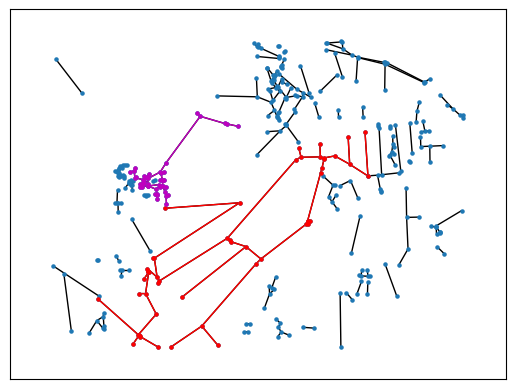

In [5]:
nx.draw_networkx(G, pos=layout, with_labels=False, node_size=5)
nx.draw_networkx(G.subgraph(list(sorted_groups[0])), pos=layout, node_color='r', \
                 edge_color='r', with_labels=False,
                 node_size=5)
nx.draw_networkx(G.subgraph(list(sorted_groups[1])), pos=layout, node_color='m', \
                 edge_color='m', with_labels=False,
                 node_size=5)

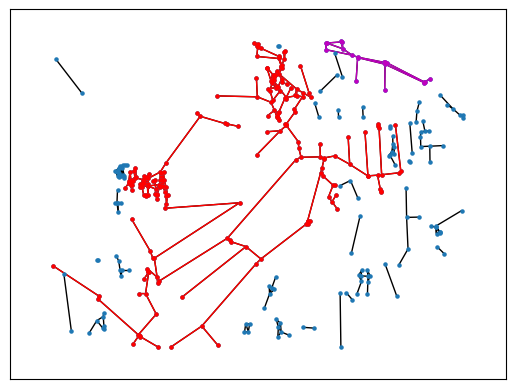

In [6]:
new_edges = set(nx.geometric_edges(G, radius=config.neighbour_eps))
edges = edges.union(new_edges)

graph = nx.Graph(edges)
new_sorted_groups = sorted(nx.connected_components(graph), \
                           key=lambda g: group_area(g, layout), reverse=True)
nx.draw_networkx(graph, pos=layout, with_labels=False, node_size=5)
nx.draw_networkx(graph.subgraph(list(new_sorted_groups[0])), pos=layout, node_color='r', \
                 edge_color='r', with_labels=False,
                 node_size=5)
nx.draw_networkx(graph.subgraph(list(new_sorted_groups[1])), pos=layout, node_color='m', \
                 edge_color='m', with_labels=False,
                 node_size=5)

In [8]:
config_zero_threshold = Config(threshold=0)
model_zero = Model(config_zero_threshold)
dol, all_nodes = model_zero.get_graph()

H = nx.Graph(dol)
layout = {node.id: (float(node.lon), float(node.lat)) for node in all_nodes}
for node_name in H.nodes:
    H.nodes[node_name]['pos'] = layout[node_name]

sorted_groups = sorted(nx.connected_components(H), \
                       key=lambda g: group_area(g, layout), reverse=True)

384683442


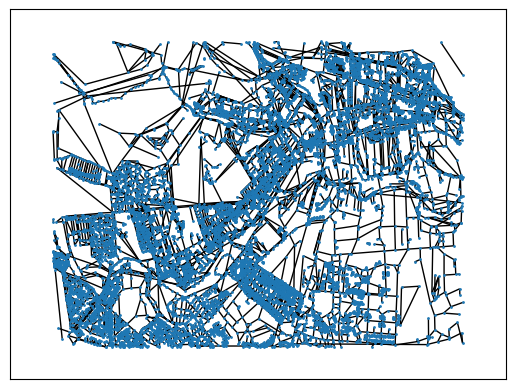

In [11]:
nx.draw_networkx(H, pos=layout, with_labels=False, node_size=1)
# nx.draw_networkx(H.subgraph(list(sorted_groups[0])), pos=layout, node_color='r', edge_color='r', with_labels=False,
#                  node_size=5)
# nx.draw_networkx(H.subgraph(list(sorted_groups[1])), pos=layout, node_color='m', edge_color='m', with_labels=False,
#                  node_size=5)

In [12]:
R = G.subgraph(list(new_sorted_groups[0]))
P = G.subgraph(list(new_sorted_groups[1]))
out = [e for e in H.edges
       if e[0] in R and e[1] in P
       or e[0] in P and e[1] in R]
out

[]

In [ ]:
len(G.edges)